In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar  
import math

In [2]:
N = norm.cdf


In [3]:
from scipy.special import erf
print(erf(1))

0.8427007929497148


In [4]:
print(N(1))
print(norm.rvs())

0.8413447460685429
-1.0270075989515595


## Setting up the params

In [37]:
option = {"T": 0.3, "x0": 250, "K": 1000, "r": 0, "sigma": 0.95}


In [38]:
TRADE_FEE = 0.3 / 100

In [39]:
option['x0']

250

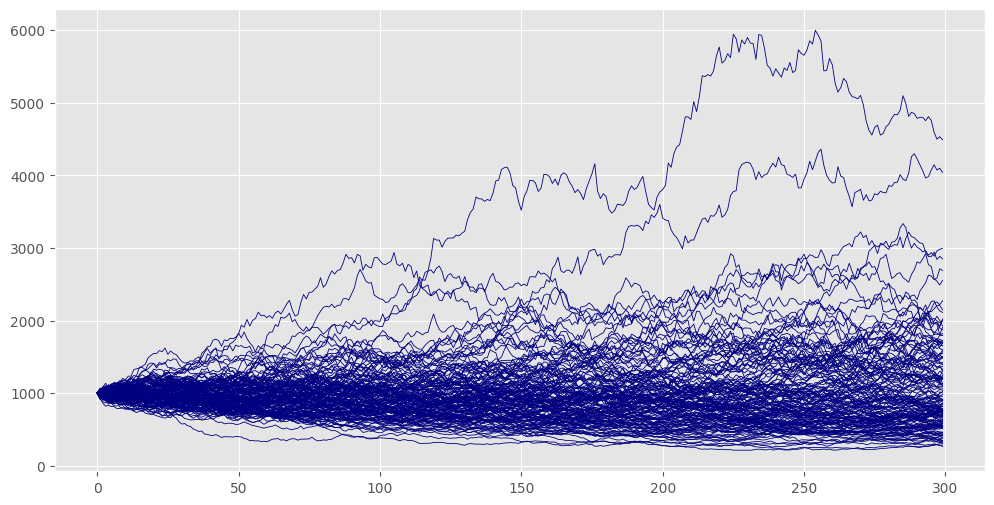

In [40]:
# geometric bwornian motions
# TODO: add taking account of risk-free rate while sampling


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline


sigma = option['sigma']
T = option['T']
K = option['K']

steps = 300
num_plots = 150
Range = []
Values = [K]


plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))


Range = np.arange(steps) 

all_paths = []

for i in range(0, num_plots):

    for i in range (1, steps):
        dx = sigma * Values[-1] * norm.rvs() * np.sqrt(T / steps)

        y = Values[-1] + dx

        Values.append(y)
    all_paths.append(Values)
    ax.plot(Range, Values)
    Values = [K]

In [41]:
print(Range)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [42]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
#     print(d1, d2)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [43]:
BS_CALL(57, 50, 0.25, 0.01, 0.5)

9.613700581442536

In [44]:
BS_PUT(57, 50, 0.25, 0.01, 0.5)

2.4888567013155427

In [45]:
T * 365 / steps * 5

1.825

In [46]:
# delta_BS_put(100,100,0.5, 0, 1)
last_prices = []
call_replicated_payoff = []
call_true_payoff = []

S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

deltas = []
usdcs = []

volumes_in_usdc = []

asset = 0
initial_usdc = 0
usdc = initial_usdc
prev_asset = 0

for i in range(len(all_paths[:])):
    asset = 0
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = 0
    volume_in_usdc = 0
    deltas.append([])
    usdcs.append([])
    
    for j in range(0, len(all_paths[i]), 2):
        t = (T / steps) * j
#         print(t)
        prev_asset = asset
        asset = delta_BS_call(all_paths[i][j], K, T - t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j]
        volume_in_usdc += abs(asset - prev_asset) * all_paths[i][j]
        deltas[i].append(asset)
        usdcs[i].append(usdc)

    last_prices.append(all_paths[i][-1])
    call_replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    call_true_payoff.append(max(0, all_paths[i][-1] - K) - BS_CALL(S0, K, T, r, sigma))
    volumes_in_usdc.append(volume_in_usdc)


# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

In [47]:
print(option)
print()
print((list(map(lambda x: round(x*TRADE_FEE,2), volumes_in_usdc))))
print()
print('-----------------')
print()
print('mean of additional trading costs')
print(sum(list(map(lambda x: round(x*TRADE_FEE,2), volumes_in_usdc)))/len(volumes_in_usdc))

{'T': 0.3, 'x0': 250, 'K': 1000, 'r': 0, 'sigma': 0.95}

[13.62, 14.17, 12.63, 14.01, 15.06, 19.34, 11.65, 5.23, 7.23, 5.58, 17.9, 10.25, 11.41, 17.39, 16.65, 16.57, 13.7, 5.79, 15.12, 16.57, 18.98, 19.7, 11.54, 5.67, 18.4, 14.39, 10.48, 9.92, 20.32, 13.88, 10.97, 11.67, 5.77, 11.23, 17.1, 9.89, 19.27, 4.47, 12.07, 13.54, 4.45, 7.07, 7.77, 7.99, 11.38, 9.35, 16.59, 18.39, 11.58, 14.99, 17.71, 9.64, 6.6, 12.33, 10.54, 16.25, 7.3, 12.67, 18.86, 7.06, 12.66, 10.62, 15.74, 10.67, 10.97, 14.43, 10.07, 7.64, 10.29, 19.19, 15.9, 17.0, 10.23, 8.06, 12.29, 13.77, 12.88, 10.07, 13.73, 13.36, 9.82, 5.66, 5.65, 15.09, 11.22, 12.25, 16.83, 14.8, 11.12, 6.09, 9.49, 14.53, 10.96, 6.44, 9.26, 9.35, 20.15, 7.5, 14.09, 5.71, 14.41, 10.5, 8.29, 9.7, 4.7, 12.06, 18.44, 11.05, 15.73, 6.85, 7.34, 13.99, 10.8, 15.13, 16.28, 15.83, 15.63, 18.92, 8.35, 7.97, 9.93, 14.0, 12.15, 7.78, 21.51, 19.94, 14.04, 17.23, 18.43, 7.37, 8.07, 6.8, 7.03, 14.89, 13.72, 9.56, 15.94, 7.22, 15.45, 9.16, 3.23, 6.32, 19.22, 5.08, 

In [49]:
BS_CALL(1000, 1000, 0.3, 0, 0.9)

194.68556207137948

In [173]:
len(all_paths[0])

300

In [174]:
len(usdcs[2])

150

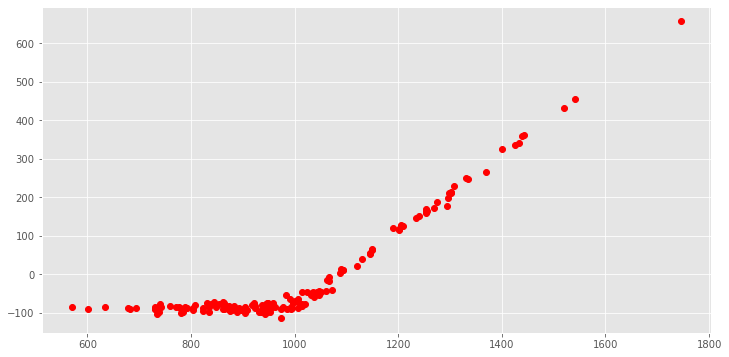

In [117]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
plt.plot(last_prices, call_replicated_payoff, 'ro', )

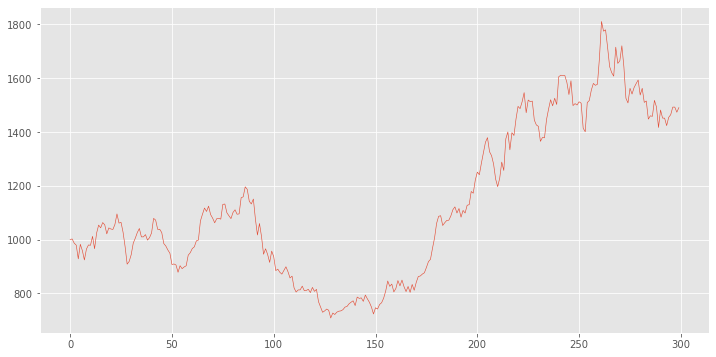

In [36]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
plt.plot(Range, all_paths[path_index])

In [37]:
import pandas as pd

In [38]:
# Carpentries link for gapminder data
data_url = 'http://bit.ly/2cLzoxH'
#load gapminder data from url as pandas dataframe
gapminder = pd.read_csv(data_url)
print(gapminder.head(3))

       country  year         pop continent  lifeExp   gdpPercap
0  Afghanistan  1952   8425333.0      Asia   28.801  779.445314
1  Afghanistan  1957   9240934.0      Asia   30.332  820.853030
2  Afghanistan  1962  10267083.0      Asia   31.997  853.100710


In [39]:
gapminder_us = gapminder[gapminder.country=="United States"]

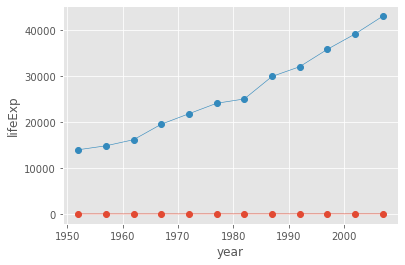

In [40]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
ax.plot(gapminder_us.year, gapminder_us.lifeExp, marker="o")
ax.set_xlabel("year")
ax.set_ylabel("lifeExp")
ax.plot(gapminder_us.year, gapminder_us["gdpPercap"], marker="o")
plt.show()

In [41]:
timeframe = list(map(lambda x: (T / steps) * x * 365, Range))
# timeframe

In [42]:
usdcs[path_index]

[-599.5276723151636,
 -601.009245425689,
 -588.6015661170612,
 -582.5211868332601,
 -542.4161259980631,
 -587.1190648951409,
 -568.3715410034091,
 -540.397579100143,
 -573.6384147563848,
 -585.9657171924129,
 -584.7758068104805,
 -611.7895965677078,
 -575.2995329924005,
 -623.2159653468976,
 -646.8547424041953,
 -638.9749165541728,
 -654.1981169348011,
 -647.6492194274891,
 -621.2843061672786,
 -638.8976685935836,
 -635.6959677287814,
 -634.2104439883273,
 -649.1220135833389,
 -680.0073759288337,
 -653.7524979955199,
 -655.7921310619063,
 -626.7640396259962,
 -583.7310538369474,
 -530.5494084701396,
 -538.8407083010862,
 -560.4177883567912,
 -596.9211397533426,
 -612.2694548018001,
 -629.6862994694563,
 -641.9258211061663,
 -616.4156843179453,
 -616.2948072266588,
 -623.2493235355862,
 -606.0476252596159,
 -613.6614503387128,
 -628.3991289655162,
 -673.7436233287077,
 -668.5615789258508,
 -640.648908963473,
 -640.8122108804896,
 -630.3665172261306,
 -596.1738029400739,
 -588.0121320193

In [43]:
path_index = 2

Initial = 2000

In [44]:
# deltas[path_index][5] 

In [45]:
params = " 'S': 1000, T': 0.5, 'Strike': 1000, 'risk-free rate': 0, 'volatility': 0.7 "
params

" 'S': 1000, T': 0.5, 'Strike': 1000, 'risk-free rate': 0, 'volatility': 0.7 "

In [46]:
option

{'T': 0.5, 'x0': 250, 'K': 1000, 'r': 0, 'sigma': 0.7}

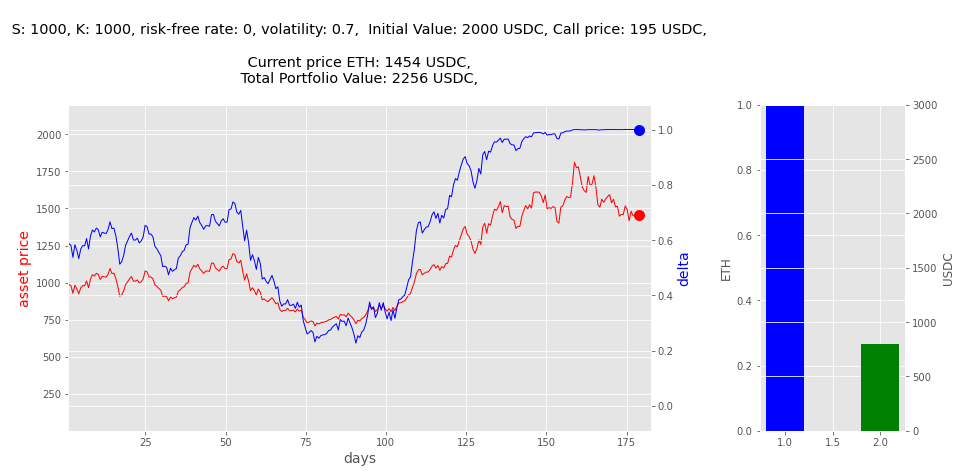

In [72]:
for i in range(len(timeframe)-5, len(timeframe), 5):
    
    _timeframe = timeframe[:i]
    _all_paths = list(map(lambda x: x[:i], all_paths))
    _deltas = list(map(lambda x: x[:i], deltas))
    _usdcs = list(map(lambda x: x[:i], usdcs))
#     print(_all_paths)

    plt.style.use('ggplot')
    plt.rcParams['lines.linewidth'] = 1

    fig, _ax = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [4, 1]})
#     print((_ax))
    ax = _ax[0]
    fig.set_figwidth(15)
    fig.set_figheight(6)
    ax.set_xlim(1, T*365)
    ax.set_ylim(1, 2200)
    fig.subplots_adjust(wspace=0.3)

    # create figure and axis objects with subplots()
    # fig,ax = plt.subplots()
    # make a plot
    ax.plot(_timeframe,
            _all_paths[path_index],
            color="red", 
            )
    # set x-axis label
    ax.set_xlabel("days", fontsize = 14)
    # set y-axis label
    ax.set_ylabel("asset price",
                  color="red",
                  fontsize=14)
    ax.plot(_timeframe[-1], _all_paths[path_index][-1], 'ro', markersize=10)


    # twin object for two different y-axis on the sample plot
    ax2 = ax.twinx()
    ax2.set_xlim(1, T*365)
    ax2.set_ylim(-0.09, 1.09)

    # make a plot with different y-axis using second axis object
    ax2.plot(_timeframe, _deltas[path_index], color="blue")
    ax2.set_ylabel("delta",color="blue",fontsize=14)
    ax2.plot(_timeframe[-1], _deltas[path_index][-1], 'bo', markersize=10)

    current_price = round(_all_paths[path_index][-1])
    total_portfolio_value = round(_usdcs[path_index][-1] + _deltas[path_index][-1] * _all_paths[path_index][-1])
    call_price = round(BS_CALL(1000, option['K'], option['T'], option['r'], option['sigma']))

    plt.title('\n S: 1000, K: 1000, risk-free rate: 0, volatility: 0.7,  Initial Value: {} USDC, Call price: {} USDC, \n\n Current price ETH: {} USDC, \n Total Portfolio Value: {} USDC, \n '.format(Initial, call_price, current_price, total_portfolio_value + Initial))
        
    ax = _ax[1]    
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.



    ax.bar(1, round(_deltas[path_index][-1], 2), color = 'b', width = 0.4)
    ax2.bar(2, round(_usdcs[path_index][-1] + Initial), color = 'g', width = 0.4)

    ax.set_ylim(0, 1)
    ax2.set_ylim(0, 3000)
    ax.set_ylabel('ETH')
    ax2.set_ylabel('USDC')


    fig.savefig('ITM_call/test{}.jpg'.format(i),
            format='jpeg',
            dpi=300,
            bbox_inches='tight')



# print(fig)





In [29]:
_all_paths[path_index][-1]

1.6831287497316655e+03

In [30]:
print(_deltas[0])

[0.5977344689084383, 0.590470887489815, 0.6389189335161229, 0.6274846553841251, 0.631990897759189, 0.6069209277923385, 0.616996218671108, 0.5869004770601125, 0.5763960423058493, 0.5673535373859774, 0.5380827575434816, 0.5207695919831926, 0.5515843415673688, 0.5264826159781757, 0.5253294897509047, 0.5281402095986558, 0.5196152176458164, 0.5301139837399774, 0.5394612930182452, 0.5463810564690689, 0.5023141303737396, 0.5050413425898695, 0.5199704214440883, 0.5384450762682006, 0.5594057417546839, 0.5703235214624854, 0.5438272842487599, 0.5509253671132127, 0.5520135804630256, 0.535807454472639, 0.5496956979294604, 0.581880859936863, 0.6362640442742932, 0.6153669922965466, 0.6541954408867757, 0.6376321705638129, 0.6516824278655622, 0.6442429569137165, 0.6175357798101384, 0.6347818003800271, 0.6393730036973364, 0.6367663911728945, 0.5956679788816687, 0.5805305956201506, 0.5557495914556734, 0.5808844840953408, 0.5751840693681207, 0.5881402224794083, 0.628195340568166, 0.6314530707229137, 0.649

In [31]:
K

1000

In [ ]:

# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')